# Solutions to Problem 9.1: Simple Variational Autoencoder (VAE)

**Course:** Data Compression With And Without Deep probabilistic models (Prof. Robert Bamler at University of Tuebingen)

- This notebook is part of the solutions to Problem Set 9, discussed on 8 June 2022.
- You can download the original problem set and the full solutions from the [course website](https://robamler.github.io/teaching/compress22/).

This problem guides you through the implementation of a simple variational autoencoder (VAE) for hand-written digits (MNIST).
On the next problem set, we will modify the VAE that you implement here so that it can be used for *lossy* data compression.

## Preparation

Let's load some libraries, set some global configurations, and load the training and test sets.

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import time

/home/robamler/Dropbox/teaching/compress22/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_CUDA = False # change to True if you have a compatible GPU
RANDOM_SEED = 20220625
BATCH_SIZE = 100
EPOCHS = 50
BATCHES_BETWEEN_LOGGING = 100
LATENT_DIM = 8

In [3]:
torch.manual_seed(RANDOM_SEED)
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

## Visualize some of the training data

The training data consists of black-and-white handwritten digits with a resolution of 28x28 pixels.

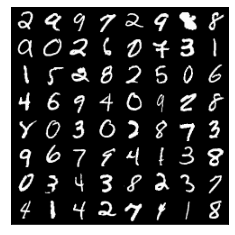

In [5]:
for batch, _ in train_loader:
    ax = plt.imshow(make_grid(batch[:64]).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    break

## Encoder and Decoder Model

The classes `Encoder` and `Decoder` define two neural networks
- `Encoder` takes a batch of images $x$ as input and outputs the parameters of the variational distribution $Q_\phi(Z\,|\,X\!=\!x) = \mathcal N\big(\mu_\phi(x),\text{diag}(\sigma^2_\phi(x))\big)$.
  More precisely, $\phi$ are the weights of the neural network, and its output is a tuple $(\mu_\phi(x), \log \sigma^2_\phi(x))$.
  Here, we output the log-variances rather than the variances so that we can ensure that the variances are always positive.
- `Decoder` takes a latent representation $z$ as input and outputs the parameters $\hat x_\theta(z)$ of the likelihood $P_\theta(X\,|\,Z\!=\!z)$.
  Here, $\theta$ are the weights of the neural network, and we model the likelihood $P_\theta(X\,|\,Z\!=\!z)$ as a Bernoulli distribution, which is a fancy way of saying that each pixel $X_i$ can be either black or white, and it is white with probability $\hat x_\theta(z) \in(0,1)$.

### Your Task

Nothing to implement for you yet.
Read the above explanation and the model definitions below and make sure you understand what's going on.

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5)
        self.fc_mean = nn.Linear(in_features=8*8*8, out_features=LATENT_DIM)
        self.fc_log_variance = nn.Linear(in_features=8*8*8, out_features=LATENT_DIM)

    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h)).view(-1, 8 * 8 * 8)
        q_mean = self.fc_mean(h)  # (no activation function on last layer)
        q_log_variance = self.fc_log_variance(h)  # (no activation function on last layer)
        return q_mean, q_log_variance

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=LATENT_DIM, out_features=8*8*8)
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        h = torch.relu(self.fc(z)).view(-1, 8, 8, 8)
        h = torch.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

## Reparameterization Gradients

In order to maximize the ELBO we will use reparameterization gradients as introduced in Problem 8.2 (b) on Problem Set 8.


### Your Task

Fill in the gaps labeled `TODO` below.
Note that the second function argument is $\texttt{log\_variance} = \log(\sigma^2)$ where $\sigma$ is the (vector of) standard deviations of $Q$.

In [8]:
def reparameterize(mean, log_variance):
    std = torch.exp(0.5 * log_variance) # calculate the standard deviations of Q
    eps = torch.randn_like(std) # draws standard normal distributed random numbers
    return mean + std * eps # see Eq. 7 on Problem Set 8

## Analytic Calculation of KL-Divergence

On Problem Set 8, we derived several equivalent formulations of the evidence lower bound (ELBO).
In this problem, we'll use the formulation given in Eq. 4 of Problem Set 8, i.e.,

$$
\text{ELBO}(\phi) = \mathbb E_{Q_\phi(Z|\mathbf{X}=\mathbf{x})}\big[ \log P(\mathbf{X}\! =\!\mathbf{x}\,|\,Z)\big] - D_\text{KL}\big(Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z)\big).
$$

Here, we *estimate* the first term on the right-hand side by drawing a random sample from $z\sim Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x})$ and then evaluating $ \log P(\mathbf{X}\! =\!\mathbf{x}\,|\,Z\!=\!z)$ for this sample.
By contrast, the second term on the right-hand side can be evaluated analytically because both the variational distribution $Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x})$ and the prior $P(Z)$ are normal distributions (we assume here the $P(Z) = \mathcal N(0, I)$ is a standard normal distribution, i.e. it has zero mean and unit standard deviation).
According to Wikipedia, the [KL-divergence between two normal distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) $\mathcal N_0$ and $\mathcal N_1$ with means $\mu_0$ and $\mu_1$, respectively, and covariance matrices $\Sigma_0$ and $\Sigma_1$, respectively, is given by

$$
  D_\text{KL}\left(\mathcal{N}_0 \parallel \mathcal{N}_1\right) =
  \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right)  - k +
    \left(\mu_1 - \mu_0\right)^\mathsf{T} \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) +
    \ln\left(\frac{\det\Sigma_1}{\det\Sigma_0}\right)
  \right).
$$
### Your Task

Complete the implementation of the function `kl_divergence_from_prior` (i.e., fill in the gap labeled with `TODO`) by evaluating the above expression for the KL-divergence.
You shouldn't have to explicitly construct any matrices.
Since all matrices are diagonal, you can rewrite everything as a simple term inside the `torch.sum(...)` below.
Use the following substitutions:
- mean of the variational distribution: $\mu_0 = \texttt{q\_mean}$
- mean of the prior: $\mu_1 = 0$
- covariance matrix of the variational distribution: $\Sigma_0 = \text{diag}(\texttt{q\_variance})$
- covariance matrix of the prior: $\Sigma_1 = I = \text{diag}(1,\ldots,1)$
- dimensionality of $Z$ (the "$-k$" term in the above KL-divergence): simply subtract $1$ inside `torch.sum(...)` below; this will subtract $1$ from each of the $k$ components over which we `sum`.
- $\det \Sigma_1 = \det I = 1$
- $\ln\det\Sigma_0 = \operatorname{tr}\ln\Sigma_0 = \texttt{torch.sum(q\_log\_variance)}$

In [9]:
def kl_divergence_from_prior(q_mean, q_log_variance):
    q_variance = q_log_variance.exp()
    return 0.5 * torch.sum(q_variance - 1 + q_mean**2 - q_log_variance)

## Evidence Lower Bound (ELBO)

The following function estimates the ELBO,
$$
\text{ELBO}(\phi) = \mathbb E_{Q_\phi(Z|\mathbf{X}=\mathbf{x})}\big[ \log P(\mathbf{X}\! =\!\mathbf{x}\,|\,Z)\big] - D_\text{KL}\big(Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z)\big).
$$

Read the implementation and make sure you understand it.

In [10]:
def elbo_and_reconstruction(encoder, decoder, x):
    q_mean, q_log_variance = encoder(x)
    z = reparameterize(q_mean, q_log_variance)
    x_reconstructed = decoder(z)
    log_likelihood = -F.binary_cross_entropy(x_reconstructed, x, reduction='sum')

    elbo = log_likelihood - kl_divergence_from_prior(q_mean, q_log_variance)
    return elbo, x_reconstructed

## Training and Testing

The remaining parts of this notebook train the VAE by maximizing the ELBO over both the encoder and the decoder parameters (i.e., via amortized variational expectation maximization).
Read the implementation, make sure you understand what is going on.
Then try it out.
You should observe that the ELBO increases over the course of training, and that both samples and reconstructions appear to increase in quality.

You could use the trained model to losslessly compress an MNIST image using bits-back coding, and the resulting net bit rate should be close to the negative ELBO (you'll have to quantize $z$-space so that you can losslessly compress $z$, but as long as your quantization grid is fine enough the precise form of quantization won't affect the net bit rate).

On the next problem set we will modify the VAE that we introduced here so that you use it for *lossy* compression.

In [11]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [12]:
def train(epoch):
    # Set encoder and decoder models into training mode.
    encoder.train()
    decoder.train()

    total_elbo = 0
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        current_elbo, _ = elbo_and_reconstruction(encoder, decoder, batch)
        loss = -current_elbo
        loss.backward()
        total_elbo += current_elbo.item()
        optimizer.step()
        if batch_idx % BATCHES_BETWEEN_LOGGING == 0:
            print(
                f'Training epoch {epoch} [{batch_idx * len(batch)}/{len(train_loader.dataset)}' +
                f' ({100. * batch_idx / len(train_loader):.0f}%)]:' +
                f' ELBO of current batch = {current_elbo.item() / (len(batch) * np.log(2)):.6f}'
            )
            sys.stdout.flush()

    return total_elbo / len(train_loader.dataset)

In [13]:
def test( render_reconstructions=False):
    # Set encoder and decoder models into evaluation mode.
    encoder.eval()
    decoder.eval()

    rendered_reconstructions = None
    total_elbo = 0
    with torch.no_grad():
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)
            current_elbo, reconstruction = elbo_and_reconstruction(encoder, decoder, batch)
            total_elbo += current_elbo
            if i == 0 and render_reconstructions:
                n = min(batch.size(0), 8)
                comparison = torch.cat([batch[:n],
                                        reconstruction.view(BATCH_SIZE, 1, 28, 28)[:n]])
                rendered_reconstructions = make_grid(comparison.cpu()).permute((1, 2, 0))

    return total_elbo / len(test_loader.dataset), rendered_reconstructions

Training epoch 1 [0/60000 (0%)]: ELBO of current batch = -733.685663
Training epoch 1 [10000/60000 (17%)]: ELBO of current batch = -387.126504
Training epoch 1 [20000/60000 (33%)]: ELBO of current batch = -325.610466
Training epoch 1 [30000/60000 (50%)]: ELBO of current batch = -284.682504
Training epoch 1 [40000/60000 (67%)]: ELBO of current batch = -266.394287
Training epoch 1 [50000/60000 (83%)]: ELBO of current batch = -263.840379
Epoch 1 of 50 (14 sec): training set ELBO = -337.1108; test set ELBO = -247.4046 (both ELBOs in base 2)



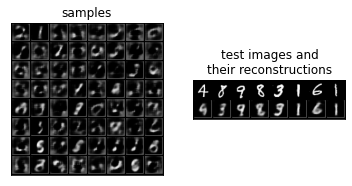

Training epoch 2 [0/60000 (0%)]: ELBO of current batch = -254.507016
Training epoch 2 [10000/60000 (17%)]: ELBO of current batch = -233.455770
Training epoch 2 [20000/60000 (33%)]: ELBO of current batch = -242.553104
Training epoch 2 [30000/60000 (50%)]: ELBO of current batch = -236.247737
Training epoch 2 [40000/60000 (67%)]: ELBO of current batch = -233.479087
Training epoch 2 [50000/60000 (83%)]: ELBO of current batch = -229.535669
Epoch 2 of 50 (15 sec): training set ELBO = -234.5166; test set ELBO = -221.9543 (both ELBOs in base 2)

Training epoch 3 [0/60000 (0%)]: ELBO of current batch = -219.018183
Training epoch 3 [10000/60000 (17%)]: ELBO of current batch = -223.016378
Training epoch 3 [20000/60000 (33%)]: ELBO of current batch = -209.409017
Training epoch 3 [30000/60000 (50%)]: ELBO of current batch = -217.491814
Training epoch 3 [40000/60000 (67%)]: ELBO of current batch = -209.924118
Training epoch 3 [50000/60000 (83%)]: ELBO of current batch = -213.533180
Epoch 3 of 50 (15

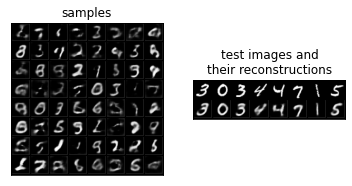

Training epoch 6 [0/60000 (0%)]: ELBO of current batch = -194.317863
Training epoch 6 [10000/60000 (17%)]: ELBO of current batch = -188.190241
Training epoch 6 [20000/60000 (33%)]: ELBO of current batch = -190.687189
Training epoch 6 [30000/60000 (50%)]: ELBO of current batch = -192.071373
Training epoch 6 [40000/60000 (67%)]: ELBO of current batch = -193.573988
Training epoch 6 [50000/60000 (83%)]: ELBO of current batch = -184.926496
Epoch 6 of 50 (18 sec): training set ELBO = -189.2884; test set ELBO = -185.4458 (both ELBOs in base 2)

Training epoch 7 [0/60000 (0%)]: ELBO of current batch = -176.939249
Training epoch 7 [10000/60000 (17%)]: ELBO of current batch = -175.317471
Training epoch 7 [20000/60000 (33%)]: ELBO of current batch = -183.981798
Training epoch 7 [30000/60000 (50%)]: ELBO of current batch = -180.905857
Training epoch 7 [40000/60000 (67%)]: ELBO of current batch = -187.686284
Training epoch 7 [50000/60000 (83%)]: ELBO of current batch = -183.212169
Epoch 7 of 50 (15

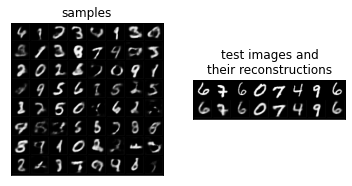

Training epoch 11 [0/60000 (0%)]: ELBO of current batch = -178.676879
Training epoch 11 [10000/60000 (17%)]: ELBO of current batch = -169.302320
Training epoch 11 [20000/60000 (33%)]: ELBO of current batch = -169.994321
Training epoch 11 [30000/60000 (50%)]: ELBO of current batch = -174.922406
Training epoch 11 [40000/60000 (67%)]: ELBO of current batch = -168.562403
Training epoch 11 [50000/60000 (83%)]: ELBO of current batch = -172.652810
Epoch 11 of 50 (15 sec): training set ELBO = -173.8862; test set ELBO = -171.8671 (both ELBOs in base 2)

Training epoch 12 [0/60000 (0%)]: ELBO of current batch = -171.484932
Training epoch 12 [10000/60000 (17%)]: ELBO of current batch = -163.010056
Training epoch 12 [20000/60000 (33%)]: ELBO of current batch = -179.453398
Training epoch 12 [30000/60000 (50%)]: ELBO of current batch = -170.033192
Training epoch 12 [40000/60000 (67%)]: ELBO of current batch = -169.023221
Training epoch 12 [50000/60000 (83%)]: ELBO of current batch = -170.613468
Epoc

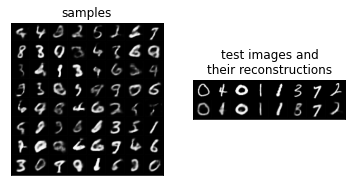

Training epoch 16 [0/60000 (0%)]: ELBO of current batch = -175.750096
Training epoch 16 [10000/60000 (17%)]: ELBO of current batch = -167.356091
Training epoch 16 [20000/60000 (33%)]: ELBO of current batch = -173.566526
Training epoch 16 [30000/60000 (50%)]: ELBO of current batch = -162.639112
Training epoch 16 [40000/60000 (67%)]: ELBO of current batch = -158.990911
Training epoch 16 [50000/60000 (83%)]: ELBO of current batch = -177.109935
Epoch 16 of 50 (14 sec): training set ELBO = -168.9164; test set ELBO = -167.3528 (both ELBOs in base 2)

Training epoch 17 [0/60000 (0%)]: ELBO of current batch = -172.342518
Training epoch 17 [10000/60000 (17%)]: ELBO of current batch = -169.511454
Training epoch 17 [20000/60000 (33%)]: ELBO of current batch = -165.716490
Training epoch 17 [30000/60000 (50%)]: ELBO of current batch = -159.459223
Training epoch 17 [40000/60000 (67%)]: ELBO of current batch = -169.255137
Training epoch 17 [50000/60000 (83%)]: ELBO of current batch = -164.529634
Epoc

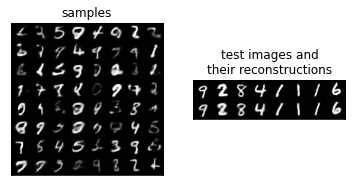

Training epoch 21 [0/60000 (0%)]: ELBO of current batch = -179.676565
Training epoch 21 [10000/60000 (17%)]: ELBO of current batch = -168.132990
Training epoch 21 [20000/60000 (33%)]: ELBO of current batch = -164.999905
Training epoch 21 [30000/60000 (50%)]: ELBO of current batch = -159.136843
Training epoch 21 [40000/60000 (67%)]: ELBO of current batch = -160.448554
Training epoch 21 [50000/60000 (83%)]: ELBO of current batch = -161.979826
Epoch 21 of 50 (15 sec): training set ELBO = -166.7131; test set ELBO = -165.2505 (both ELBOs in base 2)

Training epoch 22 [0/60000 (0%)]: ELBO of current batch = -164.486522
Training epoch 22 [10000/60000 (17%)]: ELBO of current batch = -170.425706
Training epoch 22 [20000/60000 (33%)]: ELBO of current batch = -166.660793
Training epoch 22 [30000/60000 (50%)]: ELBO of current batch = -166.568962
Training epoch 22 [40000/60000 (67%)]: ELBO of current batch = -167.651589
Training epoch 22 [50000/60000 (83%)]: ELBO of current batch = -171.109591
Epoc

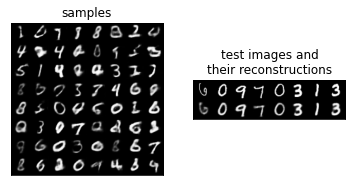

Training epoch 26 [0/60000 (0%)]: ELBO of current batch = -161.000272
Training epoch 26 [10000/60000 (17%)]: ELBO of current batch = -164.578043
Training epoch 26 [20000/60000 (33%)]: ELBO of current batch = -169.011470
Training epoch 26 [30000/60000 (50%)]: ELBO of current batch = -164.079060
Training epoch 26 [40000/60000 (67%)]: ELBO of current batch = -171.584173
Training epoch 26 [50000/60000 (83%)]: ELBO of current batch = -167.145054
Epoch 26 of 50 (15 sec): training set ELBO = -165.3020; test set ELBO = -164.6558 (both ELBOs in base 2)

Training epoch 27 [0/60000 (0%)]: ELBO of current batch = -163.128557
Training epoch 27 [10000/60000 (17%)]: ELBO of current batch = -172.907874
Training epoch 27 [20000/60000 (33%)]: ELBO of current batch = -164.814862
Training epoch 27 [30000/60000 (50%)]: ELBO of current batch = -169.219351
Training epoch 27 [40000/60000 (67%)]: ELBO of current batch = -157.983363
Training epoch 27 [50000/60000 (83%)]: ELBO of current batch = -165.522290
Epoc

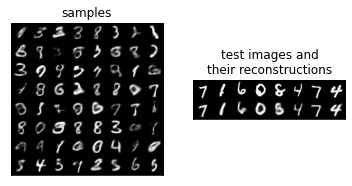

Training epoch 31 [0/60000 (0%)]: ELBO of current batch = -167.551911
Training epoch 31 [10000/60000 (17%)]: ELBO of current batch = -164.073438
Training epoch 31 [20000/60000 (33%)]: ELBO of current batch = -164.696432
Training epoch 31 [30000/60000 (50%)]: ELBO of current batch = -166.101411
Training epoch 31 [40000/60000 (67%)]: ELBO of current batch = -159.590221
Training epoch 31 [50000/60000 (83%)]: ELBO of current batch = -163.754946
Epoch 31 of 50 (15 sec): training set ELBO = -164.3784; test set ELBO = -163.3739 (both ELBOs in base 2)

Training epoch 32 [0/60000 (0%)]: ELBO of current batch = -166.127461
Training epoch 32 [10000/60000 (17%)]: ELBO of current batch = -176.263746
Training epoch 32 [20000/60000 (33%)]: ELBO of current batch = -160.614732
Training epoch 32 [30000/60000 (50%)]: ELBO of current batch = -171.877249
Training epoch 32 [40000/60000 (67%)]: ELBO of current batch = -167.685882
Training epoch 32 [50000/60000 (83%)]: ELBO of current batch = -162.510551
Epoc

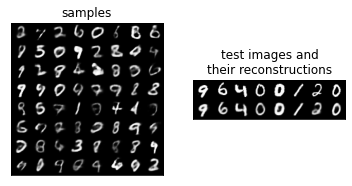

Training epoch 36 [0/60000 (0%)]: ELBO of current batch = -175.765749
Training epoch 36 [10000/60000 (17%)]: ELBO of current batch = -162.257291
Training epoch 36 [20000/60000 (33%)]: ELBO of current batch = -162.493476
Training epoch 36 [30000/60000 (50%)]: ELBO of current batch = -165.196754
Training epoch 36 [40000/60000 (67%)]: ELBO of current batch = -170.191649
Training epoch 36 [50000/60000 (83%)]: ELBO of current batch = -161.059178
Epoch 36 of 50 (14 sec): training set ELBO = -163.6511; test set ELBO = -162.9007 (both ELBOs in base 2)

Training epoch 37 [0/60000 (0%)]: ELBO of current batch = -161.499862
Training epoch 37 [10000/60000 (17%)]: ELBO of current batch = -169.537589
Training epoch 37 [20000/60000 (33%)]: ELBO of current batch = -167.496838
Training epoch 37 [30000/60000 (50%)]: ELBO of current batch = -164.035145
Training epoch 37 [40000/60000 (67%)]: ELBO of current batch = -165.315508
Training epoch 37 [50000/60000 (83%)]: ELBO of current batch = -161.304013
Epoc

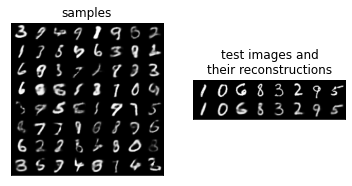

Training epoch 41 [0/60000 (0%)]: ELBO of current batch = -161.948661
Training epoch 41 [10000/60000 (17%)]: ELBO of current batch = -159.494149
Training epoch 41 [20000/60000 (33%)]: ELBO of current batch = -167.141884
Training epoch 41 [30000/60000 (50%)]: ELBO of current batch = -155.985188
Training epoch 41 [40000/60000 (67%)]: ELBO of current batch = -168.625902
Training epoch 41 [50000/60000 (83%)]: ELBO of current batch = -160.261694
Epoch 41 of 50 (15 sec): training set ELBO = -163.0204; test set ELBO = -161.8487 (both ELBOs in base 2)

Training epoch 42 [0/60000 (0%)]: ELBO of current batch = -163.790436
Training epoch 42 [10000/60000 (17%)]: ELBO of current batch = -162.993107
Training epoch 42 [20000/60000 (33%)]: ELBO of current batch = -168.923317
Training epoch 42 [30000/60000 (50%)]: ELBO of current batch = -161.091455
Training epoch 42 [40000/60000 (67%)]: ELBO of current batch = -168.039286
Training epoch 42 [50000/60000 (83%)]: ELBO of current batch = -163.714694
Epoc

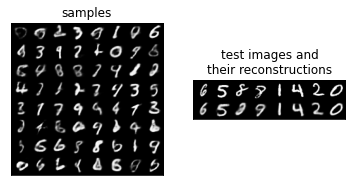

Training epoch 46 [0/60000 (0%)]: ELBO of current batch = -162.671756
Training epoch 46 [10000/60000 (17%)]: ELBO of current batch = -165.888853
Training epoch 46 [20000/60000 (33%)]: ELBO of current batch = -158.817632
Training epoch 46 [30000/60000 (50%)]: ELBO of current batch = -155.745411
Training epoch 46 [40000/60000 (67%)]: ELBO of current batch = -166.624360
Training epoch 46 [50000/60000 (83%)]: ELBO of current batch = -159.775841
Epoch 46 of 50 (14 sec): training set ELBO = -162.6078; test set ELBO = -161.5081 (both ELBOs in base 2)

Training epoch 47 [0/60000 (0%)]: ELBO of current batch = -164.586595
Training epoch 47 [10000/60000 (17%)]: ELBO of current batch = -165.449592
Training epoch 47 [20000/60000 (33%)]: ELBO of current batch = -158.191878
Training epoch 47 [30000/60000 (50%)]: ELBO of current batch = -165.782820
Training epoch 47 [40000/60000 (67%)]: ELBO of current batch = -166.688506
Training epoch 47 [50000/60000 (83%)]: ELBO of current batch = -162.146003
Epoc

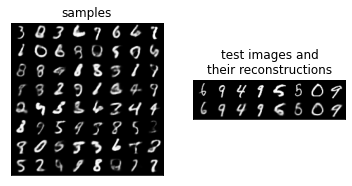

In [14]:
def create_figure():
    figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)
    samples_plot.set_title('samples')
    samples_plot.xaxis.set_visible(False)
    samples_plot.yaxis.set_visible(False)
    reconstructions_plot.set_title('test images and\ntheir reconstructions')
    reconstructions_plot.xaxis.set_visible(False)
    reconstructions_plot.yaxis.set_visible(False)
    return figure, samples_plot, reconstructions_plot

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    show_plots = epoch == 1 or epoch % 5 == 0  

    train_elbo = train(epoch)
    test_elbo, reconstructions = test(render_reconstructions=show_plots)
    end_time = time.time()
    print(
        f'Epoch {epoch} of {EPOCHS} ({end_time - start_time:.0f} sec): ' +
        f'training set ELBO = {train_elbo/np.log(2):.4f}; ' +
        f'test set ELBO = {test_elbo/np.log(2):.4f} ' +
        '(both ELBOs in base 2)\n'
    )

    if show_plots:
        figure, samples_plot, reconstructions_plot = create_figure()
        with torch.no_grad():
            sample = torch.randn(64, LATENT_DIM).to(device)
            sample = decoder(sample).cpu()
            samples_plot.imshow(make_grid(sample.view(64, 1, 28, 28)).permute((1, 2, 0)))
        reconstructions_plot.imshow(reconstructions)
        plt.show()